# **Task: Apply transfer learning using a pre-trained CNN model (e.g., VGG, ResNet) to build a small drone detection system. Fine-tune the pre-trained model on a small dataset of drone images, adjusting the final layers for binary classification (drone vs. non-drone). Evaluate the performance of the fine-tuned model on a separate test dataset and compare it with training from scratch. Provide detailed documentation explaining your design choices and algorithm architecture.**

For this task I collected the Drone images from Kagel. Then I did annotation using lebelimg. I take 526 drone images for this task.After annotation I build YOLOv8 model for drone detection.

Impoert Import necessary libraries

In [51]:
import glob
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#!pip install -q ultralytics

In [34]:
import shutil
from tqdm import tqdm


In [35]:
 #Get the list of files in the images and labels directories
images = [os.path.join('/content/drive/MyDrive/dataset_xml_format/drone_image', file) for file in os.listdir('/content/drive/MyDrive/dataset_xml_format/drone_image')]
labels = [os.path.join('/content/drive/MyDrive/dataset_xml_format/label_image', file) for file in os.listdir('/content/drive/MyDrive/dataset_xml_format/label_image')]

split the data set

In [36]:
from sklearn.model_selection import train_test_split
split = train_test_split(images, labels, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

In [37]:
# Define directory paths
TRAIN_IMAGE_DIR = '/content/drive/MyDrive/dataset_xml_format/train/images'
TRAIN_LABEL_DIR = '/content/drive/MyDrive/dataset_xml_format/train/labels'
VAL_IMAGE_DIR = '/content/drive/MyDrive/dataset_xml_format/valid/images'
VAL_LABEL_DIR = '/content/drive/MyDrive/dataset_xml_format/valid/labels'

# Create directories if they don't exist
os.makedirs(TRAIN_IMAGE_DIR, exist_ok=True)
os.makedirs(TRAIN_LABEL_DIR, exist_ok=True)
os.makedirs(VAL_IMAGE_DIR, exist_ok=True)
os.makedirs(VAL_LABEL_DIR, exist_ok=True)

# Copy images to train and validation directories
for path in tqdm(trainImages):
    shutil.copyfile(path, os.path.join(TRAIN_IMAGE_DIR, os.path.basename(path)))

for path in tqdm(testImages):
    shutil.copyfile(path, os.path.join(VAL_IMAGE_DIR, os.path.basename(path)))

# Copy labels to train and validation directories
for path in tqdm(trainTargets):
    shutil.copyfile(path, os.path.join(TRAIN_LABEL_DIR, os.path.basename(path)))

for path in tqdm(testTargets):
    shutil.copyfile(path, os.path.join(VAL_LABEL_DIR, os.path.basename(path)))

100%|██████████| 53/53 [00:23<00:00,  2.21it/s]


# Dataset Configuration
# This YAML file contains configuration information for the drone dataset.

# Dataset Path

In [39]:
%%writefile drone.yaml

path: /content/drive/MyDrive/dataset_xml_format

train: train/images
val: valid/images

nc: 1

# Classes
names: ['drone']


Writing drone.yaml


In [40]:
# Disable wandb
import os
os.environ['WANDB_DISABLED'] = 'true'

In [41]:
from ultralytics import YOLO
# Load a model
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 107MB/s]


In [43]:
# Use the model
results = model.train(
   data='drone.yaml',
   imgsz=256,
   epochs=10,
   batch=8,
   name='yolov8s_v8_50e'
)  # train the model

Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=drone.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /content/drive/MyDrive/dataset_xml_format/train/labels.cache... 428 images, 43 backgrounds, 0 corrupt: 100%|██████████| 471/471 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/dataset_xml_format/valid/labels.cache... 10 images, 43 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_v8_50e2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8s_v8_50e2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.114      1.329      1.248          7        256: 100%|██████████| 59/59 [03:20<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.12s/it]

                   all         53         11      0.157      0.545      0.164     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       1.26      1.188      1.341          6        256: 100%|██████████| 59/59 [03:15<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]

                   all         53         11      0.102      0.455      0.144     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.324      1.207        1.4          5        256: 100%|██████████| 59/59 [03:14<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]

                   all         53         11     0.0658      0.364     0.0619     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.263      1.153      1.367          6        256: 100%|██████████| 59/59 [03:17<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]

                   all         53         11      0.226      0.545      0.239      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.181     0.9904      1.309          7        256: 100%|██████████| 59/59 [03:15<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]

                   all         53         11      0.174      0.636      0.154     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.126     0.9078      1.255          6        256: 100%|██████████| 59/59 [03:13<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]

                   all         53         11      0.136      0.545      0.118     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G       1.12     0.8902      1.249          7        256: 100%|██████████| 59/59 [03:12<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]

                   all         53         11      0.172      0.818      0.197      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.019     0.8006      1.192          5        256: 100%|██████████| 59/59 [03:23<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]

                   all         53         11      0.191      0.727      0.184      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      0.953     0.7653      1.168          5        256: 100%|██████████| 59/59 [03:26<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]

                   all         53         11      0.211      0.818      0.183      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.9103     0.6913      1.115          6        256: 100%|██████████| 59/59 [03:22<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]

                   all         53         11      0.201      0.818      0.187      0.131



10 epochs completed in 0.579 hours.
Optimizer stripped from runs/detect/yolov8s_v8_50e2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_v8_50e2/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_v8_50e2/weights/best.pt...
Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


                   all         53         11      0.172      0.818        0.2      0.134
Speed: 0.7ms preprocess, 115.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/yolov8s_v8_50e2


In [44]:
import math
import random

# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=None, num_cols=1):
    """
    Function accepts a list of images and plots
    """
    image_names = sorted(glob.glob(os.path.join(result_dir, '*.jpg')))

    if num_samples is not None:
        image_names = random.sample(image_names, num_samples)

    num_images = len(image_names)
    num_rows = int(math.ceil(num_images / num_cols))
    plt.figure(figsize=(12 * num_cols, 6 * num_rows))

    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

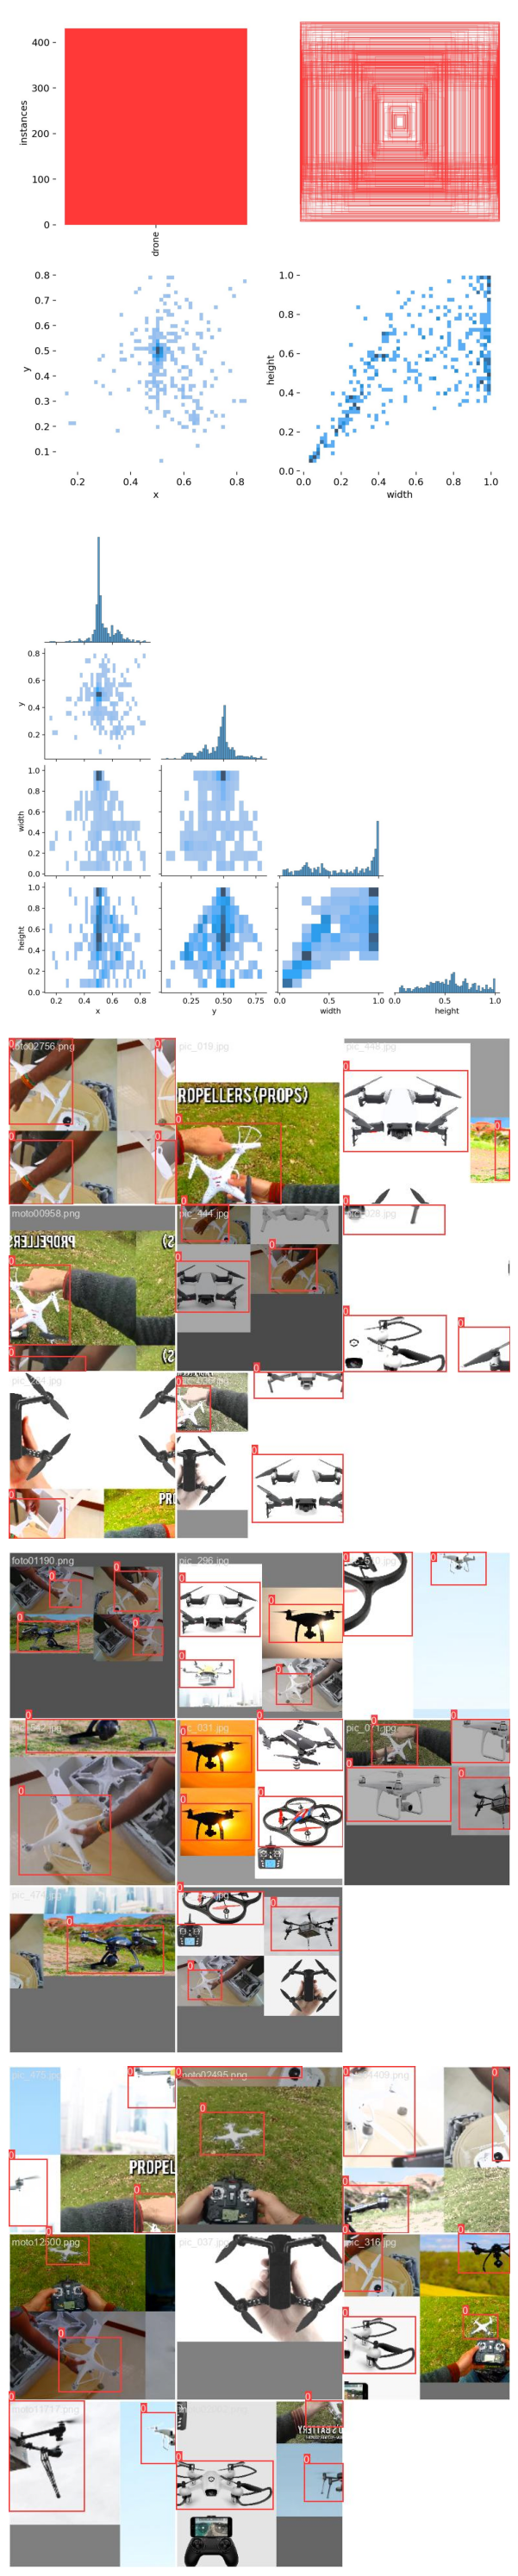

In [45]:
visualize('runs/detect/yolov8s_v8_50e', num_cols=1)


image 1/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto00987.png: 160x256 (no detections), 200.6ms
image 2/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto01451.png: 160x256 (no detections), 118.9ms
image 3/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto01625.png: 160x256 (no detections), 116.9ms
image 4/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto01654.png: 160x256 (no detections), 125.5ms
image 5/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto04351.png: 160x256 (no detections), 128.0ms
image 6/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto04989.png: 160x256 1 drone, 129.9ms
image 7/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto05047.png: 160x256 2 drones, 127.8ms
image 8/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto14414.png: 160x256 (no detections), 127.5ms
image 9/53 /content/drive/MyDrive/dataset_xml_format/valid/images/foto14733.png: 160x256 1 drone, 118.

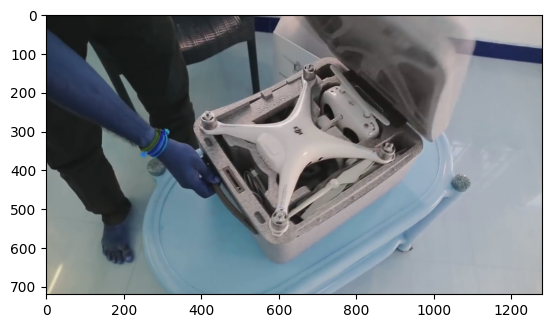

In [49]:
#predict on an image
results = model("/content/drive/MyDrive/dataset_xml_format/valid/images", conf=0.5, agnostic_nms=True, iou=0.5, save=True)
res_plotted = results[0].plot()
plt.imshow(res_plotted)
plt.show()

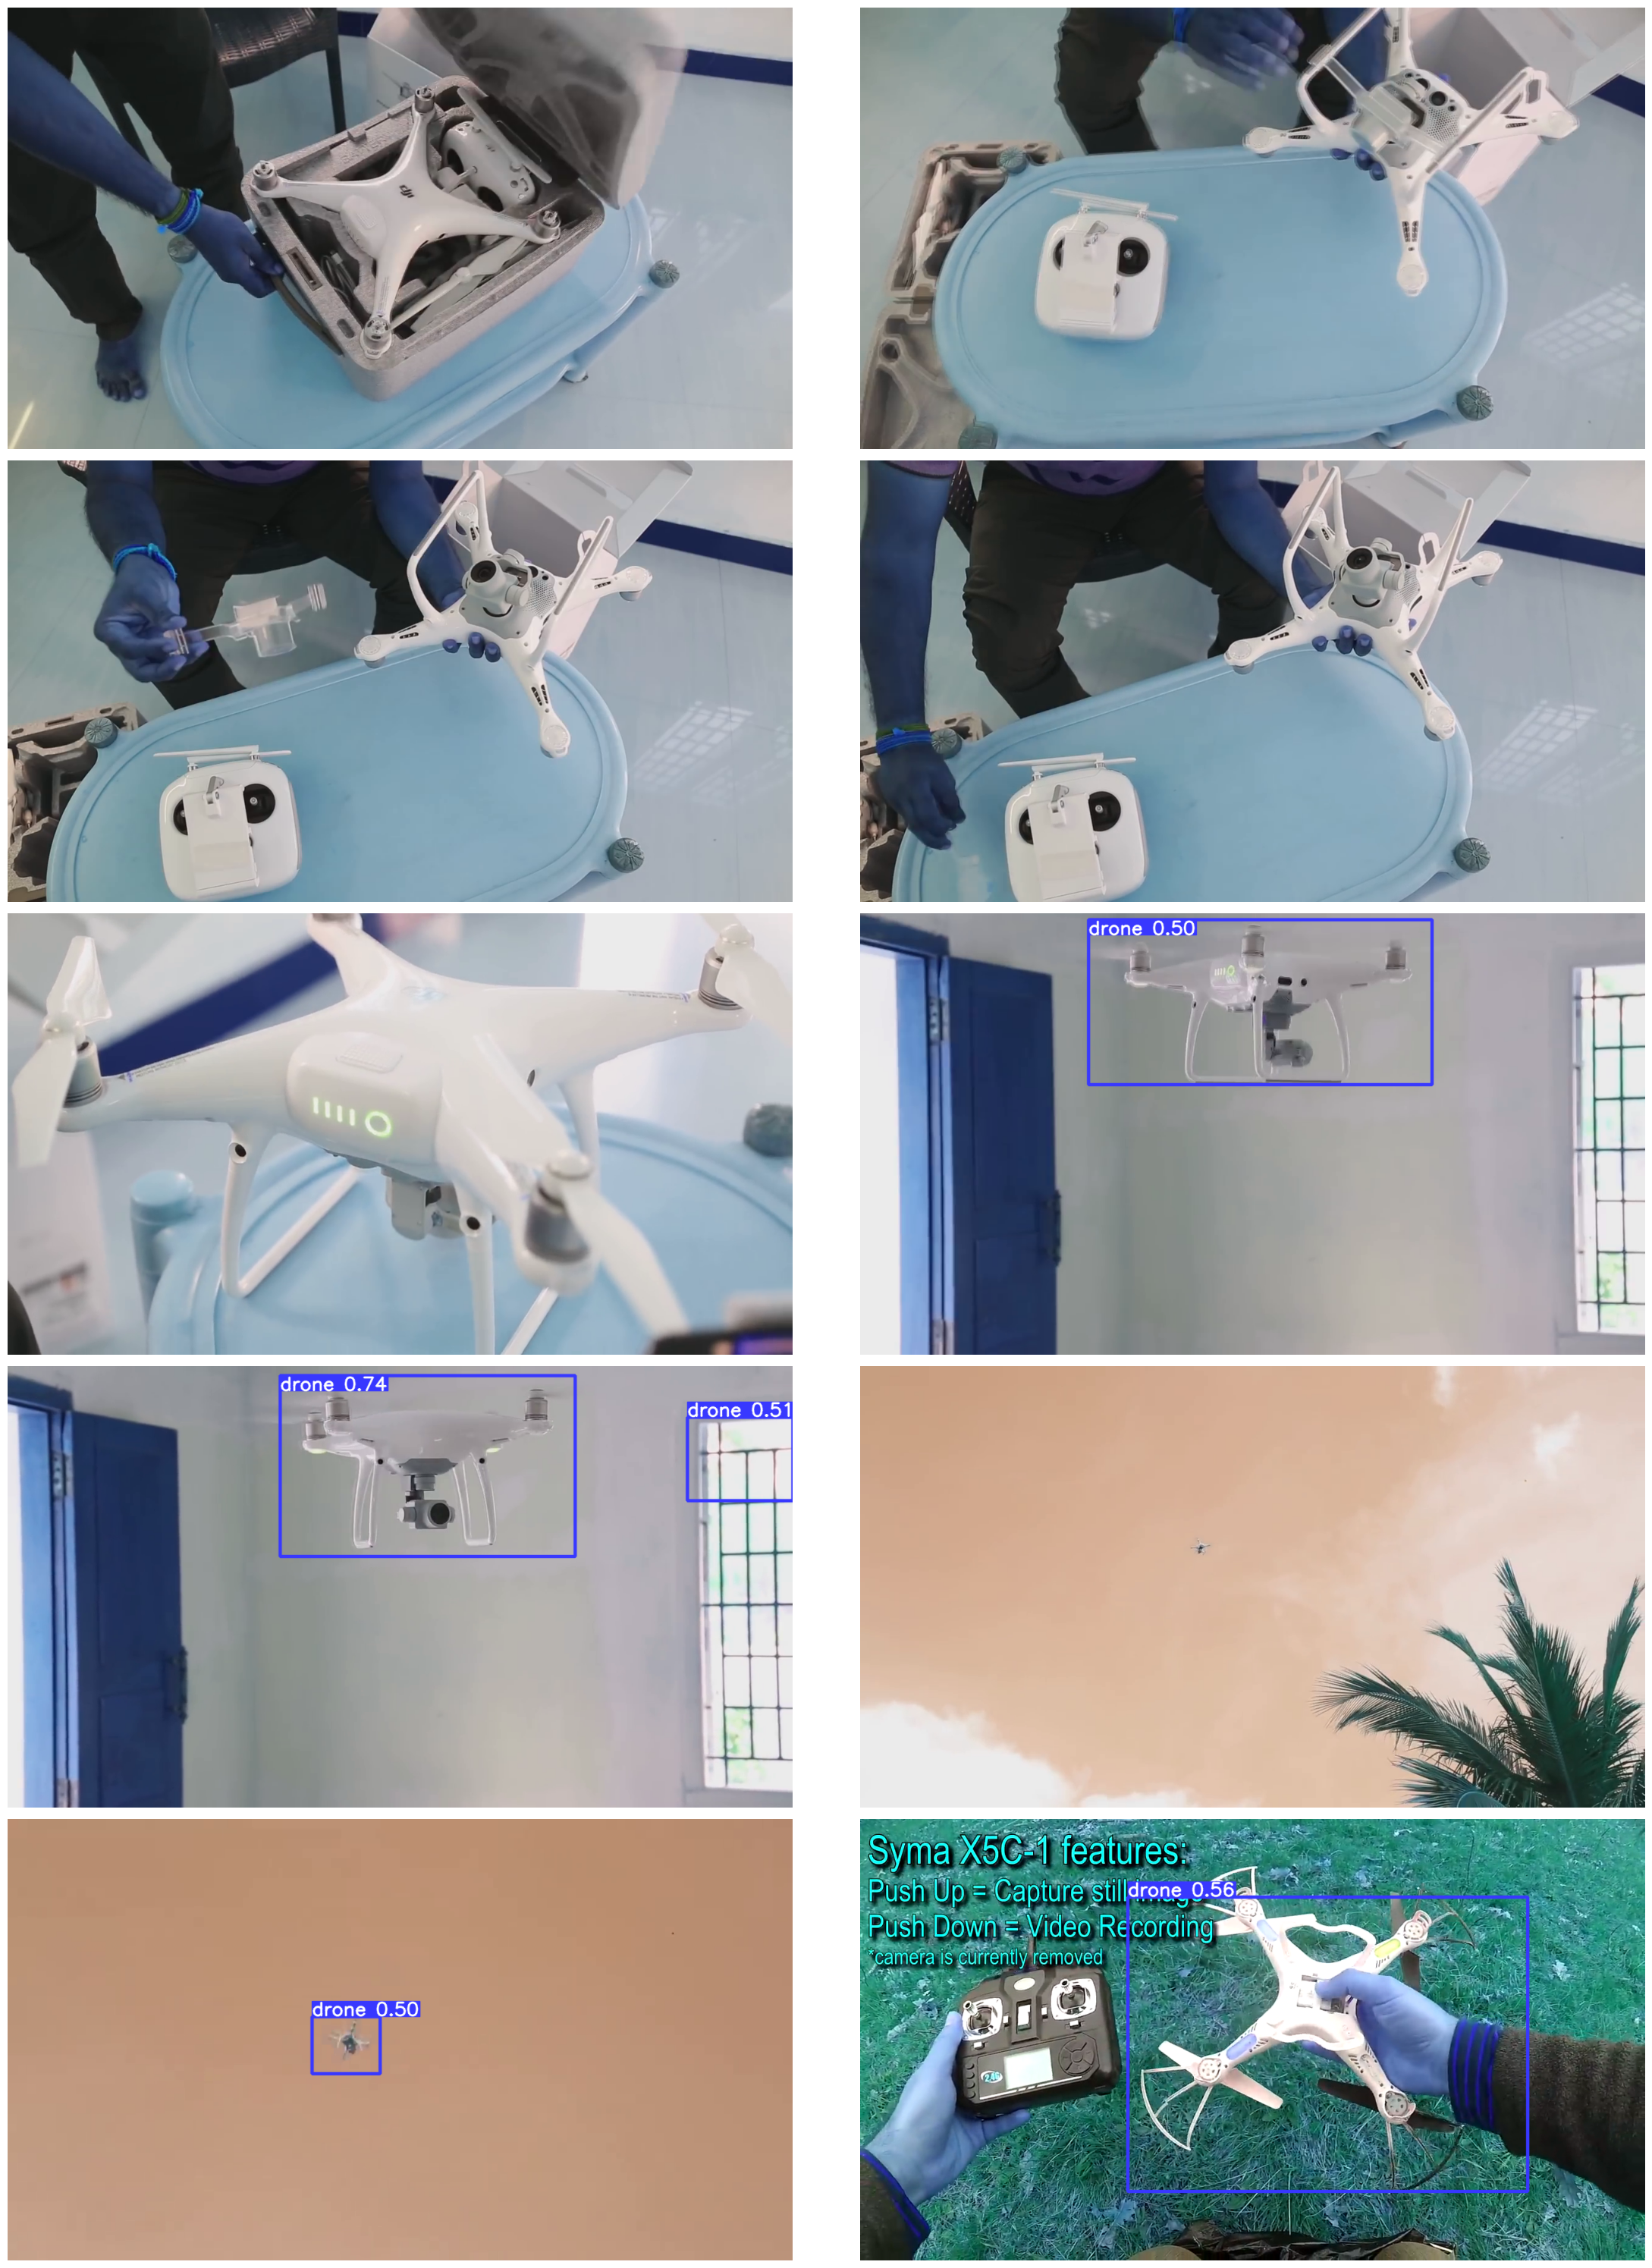

In [50]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))

for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()



image 1/6 /content/drive/MyDrive/dataset_xml_format/new_test_data/download (1).jpeg: 160x256 1 drone, 128.3ms
image 2/6 /content/drive/MyDrive/dataset_xml_format/new_test_data/download (2).jpeg: 192x256 1 drone, 91.6ms
image 3/6 /content/drive/MyDrive/dataset_xml_format/new_test_data/download (3).jpeg: 192x256 1 drone, 85.7ms
image 4/6 /content/drive/MyDrive/dataset_xml_format/new_test_data/download (4).jpeg: 192x256 (no detections), 89.7ms
image 5/6 /content/drive/MyDrive/dataset_xml_format/new_test_data/download.jpeg: 160x256 1 drone, 84.5ms
image 6/6 /content/drive/MyDrive/dataset_xml_format/new_test_data/images.jpeg: 192x256 (no detections), 89.7ms
Speed: 1.0ms preprocess, 94.9ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 256)
Results saved to runs/detect/yolov8s_v8_50e24


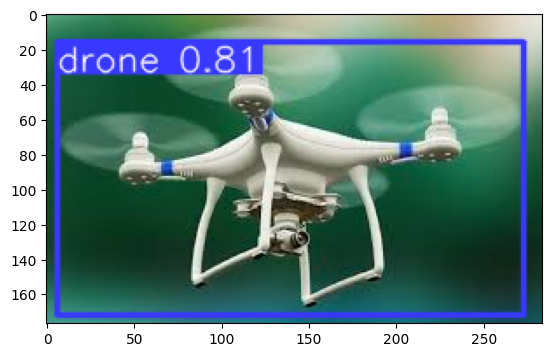

In [54]:
#predict on an new_test_data
results2 = model("/content/drive/MyDrive/dataset_xml_format/new_test_data", conf=0.5, agnostic_nms=True, iou=0.5, save=True)
res_plotted = results[0].plot()
plt.imshow(res_plotted)
plt.show()

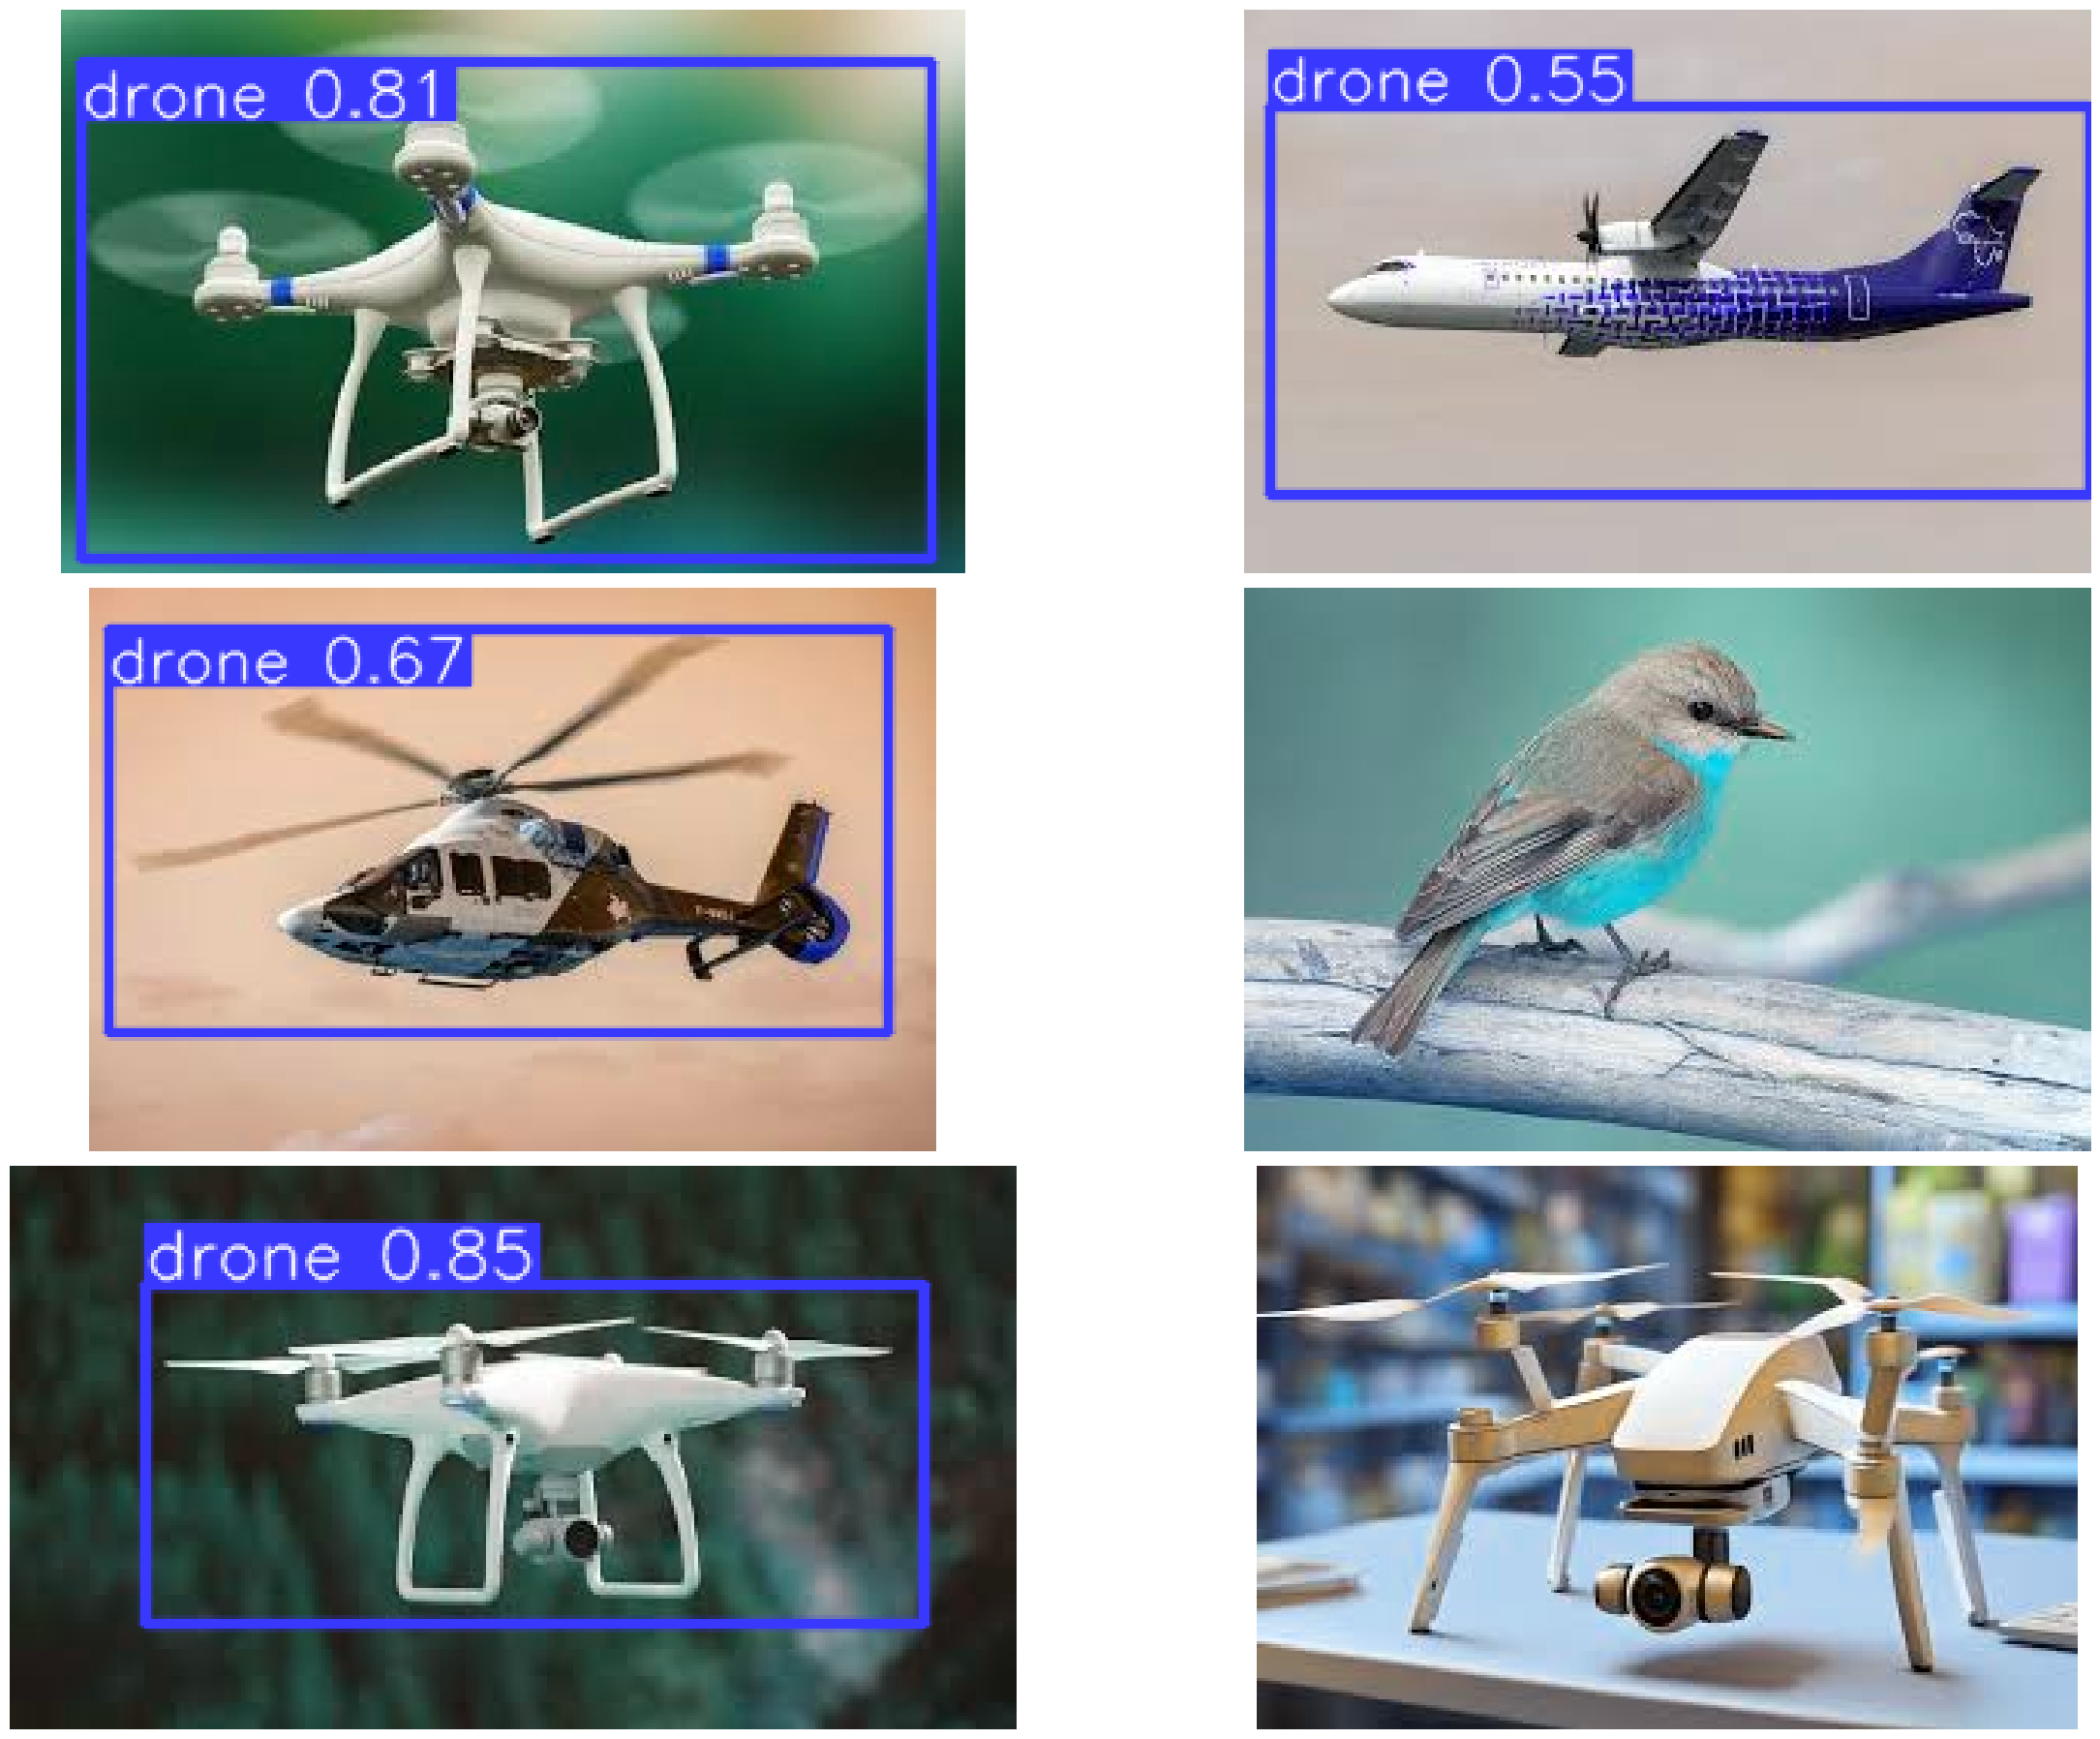

In [56]:
indices = list(range(len(results2)))
random_indices = random.sample(indices, 6)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))

for i, idx in enumerate(random_indices):
    image = results2[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()